In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold
import lightgbm as lgb
import itertools
from sklearn.metrics import roc_auc_score
import gc
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

In [8]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Dataset Loading and Merging

In [6]:
train_trains = pd.read_csv('../input/train_transaction.csv', index_col = 'TransactionID')
train_id = pd.read_csv('../input/train_identity.csv', index_col = 'TransactionID')
test_trains = pd.read_csv('../input/test_transaction.csv', index_col = 'TransactionID')
test_id = pd.read_csv('../input/test_identity.csv', index_col = 'TransactionID')

In [9]:
train_trains = reduce_mem_usage(train_trains)
train_id = reduce_mem_usage(train_id)
test_trains = reduce_mem_usage(test_trains)
test_id = reduce_mem_usage(test_id)

Memory usage of dataframe is 1775.15 MB --> 544.60 MB (Decreased by 69.3%)
Memory usage of dataframe is 45.12 MB --> 26.41 MB (Decreased by 41.5%)
Memory usage of dataframe is 1519.24 MB --> 474.52 MB (Decreased by 68.8%)
Memory usage of dataframe is 44.39 MB --> 25.98 MB (Decreased by 41.5%)


In [10]:
train = pd.merge(train_trains, train_id, on ='TransactionID', how = 'left')
test = pd.merge(test_trains, test_id, on = 'TransactionID', how = 'left')
train = train.reset_index()
test = test.reset_index()
print(train.shape)
print(test.shape)

(590540, 434)
(506691, 433)


In [11]:
del train_id, train_trains, test_id, test_trains
gc.collect()

134

In [14]:
train['isFraud'].value_counts(normalize = True)*100

0    96.500999
1     3.499001
Name: isFraud, dtype: float64

There is an imbalanced class problem

In [12]:
print('THERE ARE {0} MISSING VALUES IN TRAIN'.format(train.isnull().any().sum()))

THERE ARE 414 MISSING VALUES IN TRAIN


## Visualizations

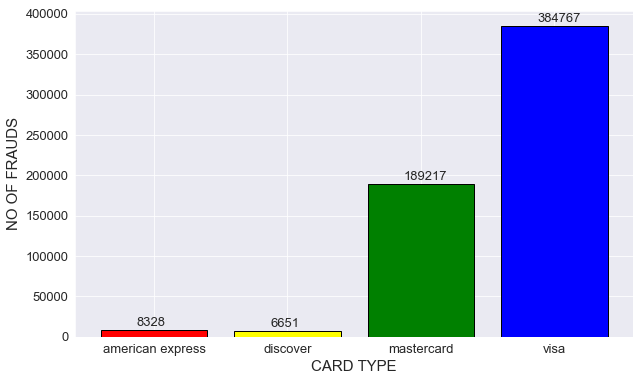

In [13]:
card_fraud = train[['isFraud', 'card4']].groupby(by = 'card4').count()
card_fraud = card_fraud.reset_index()
plt.figure(figsize = (10,6))
axes = plt.bar(x = card_fraud['card4'], height = card_fraud['isFraud'], color = ['red', 'yellow', 'green', 'blue'], edgecolor = 'Black')
plt.tick_params(labelsize = 13)
plt.xlabel('CARD TYPE', fontdict = {'fontsize':15})
plt.ylabel('NO OF FRAUDS', fontdict = {'fontsize':15})
for ax in axes.patches:
    plt.text(ax.get_x() + 0.27, ax.get_height() + 5000, str(round(ax.get_height(), 2)), fontdict= {'fontsize':13})
plt.show()

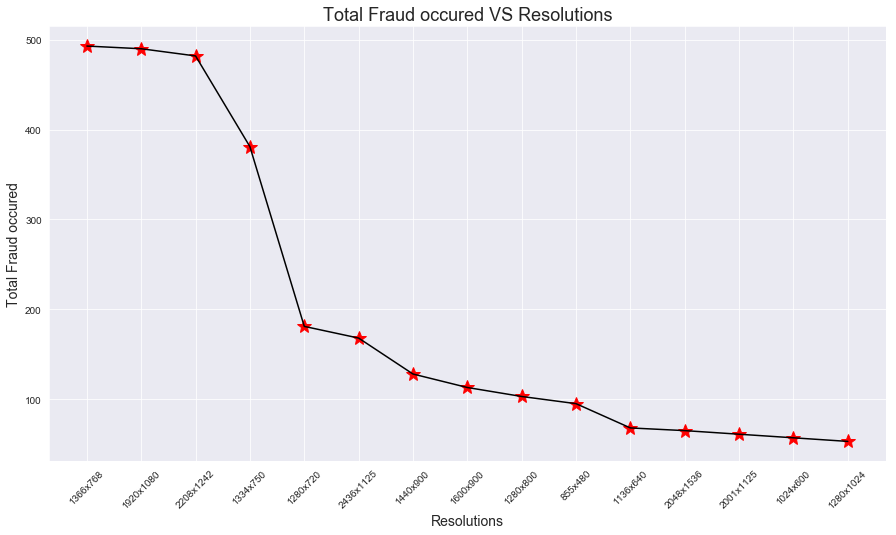

In [15]:
res_fraud = train[['isFraud', 'id_33']].groupby(by = 'id_33').sum().reset_index()
res_fraud = res_fraud.sort_values(by = 'isFraud', ascending = False)
res_fraud = res_fraud[:15][:]
plt.figure(figsize = (15,8))
plt.plot(res_fraud['id_33'], res_fraud['isFraud'],'*', color = 'red', markersize = 15)
plt.plot(res_fraud['id_33'], res_fraud['isFraud'], color = 'black') 
plt.xticks(rotation = 45)
plt.xlabel('Resolutions', fontdict = {'fontsize':14})
plt.ylabel('Total Fraud occured', fontdict = {'fontsize':14})
plt.title('Total Fraud occured VS Resolutions', fontdict = {'fontsize':18})
plt.show()

In [39]:
def label_collector(string):
    label = string.split('.')[0]
    return label

temp = train['P_emaildomain'].astype(str)
train['label_encode'] = temp.apply(label_collector)
train = train.drop('label_encode', axis=1)

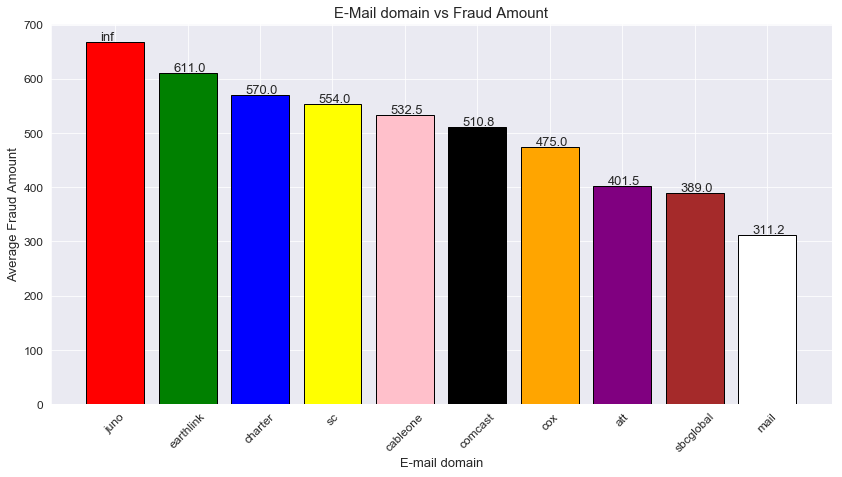

In [20]:
card_cost = train[['label_encode', 'TransactionAmt','isFraud']][train['isFraud']==1].groupby(by = 'label_encode').mean().reset_index()
card_cost = card_cost.sort_values(by = 'TransactionAmt', ascending = False)
plt.figure(figsize = (14,7))
plt.xticks(rotation = 45)
plt.xlabel('E-mail domain', fontdict = {'fontsize':13})
plt.ylabel('Average Fraud Amount', fontdict = {'fontsize':13})
plt.tick_params(labelsize = 12)
axes = plt.bar(x = card_cost['label_encode'].iloc[0:10], height = card_cost['TransactionAmt'].iloc[0:10], color = ['red','green', 'blue', 'yellow', 'pink', 'black', 'orange','purple', 'brown', 'white'], edgecolor = 'black')
for ax in axes.patches:
    plt.text(ax.get_x() + 0.2, ax.get_height() + 3, str(round(ax.get_height(), 2)), fontdict= {'fontsize':13})
plt.title('E-Mail domain vs Fraud Amount', fontdict = {'fontsize':15})
plt.show()

## Handling Missing Values and Encoding Necessary Columns

In [21]:
cols_drop_train = [cols for cols in train.columns if train[cols].isnull().sum()/ train.shape[0] > 0.9]
cols_drop_test = [cols for cols in test.columns if test[cols].isnull().sum()/ test.shape[0]> 0.9]
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
drop_cols = list(set(cols_drop_train + cols_drop_test + big_top_value_cols + big_top_value_cols_test))
drop_cols.remove('isFraud')

print("Going to drop the following columns")
print(drop_cols)

In [24]:
train.drop(drop_cols, axis = 1, inplace = True)
test.drop(drop_cols, axis = 1, inplace = True)

del cols_drop_test, cols_drop_train, big_top_value_cols, big_top_value_cols_test, drop_cols

In [25]:
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

Should consider removing P/R_emaildomain since that is redundant

In [30]:
print("String columns")
print([cols for cols in train.columns if train[cols].dtype == 'O'])

String columns
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'label_encode', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']


In [41]:
def labelencode(train,test):
    for col in train.drop(['TransactionID','isFraud','TransactionDT'],axis = 1).columns:
        if train[col].dtype == 'O' or test[col].dtype == 'O':
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))
    return train,test

In [42]:
train, test = labelencode(train, test)

In [43]:
y_test = train['isFraud']

In [44]:
cols_drops = ['TransactionID','isFraud','TransactionDT']
train = train.drop(cols_drops, axis = 1)

In [46]:
train.columns

Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2',
       ...
       'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'P_emaildomain_1',
       'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1',
       'R_emaildomain_2', 'R_emaildomain_3'],
      dtype='object', length=355)

In [47]:
# TODO more date time engineering
test = test.drop(['TransactionID','TransactionDT'], axis = 1)

In [48]:
train = train.fillna(-999)
test = test.fillna(-999)

In [49]:
## Modelling the Dataset
train_m, val_m_train, val1, val2 = train_test_split(train,y_test, test_size = 0.3, random_state = 10, stratify = y_test)
train_m_index = train_m.index
val_m_index = val_m_train.index
val1_index = val1.index
val2_index = val2.index

In [50]:
val_m_train.shape

(177162, 355)

## Bayesian Optimization for Hyperparameter Optimization

In [52]:
def objective(num_leaves,min_child_weight,feature_fraction,bagging_fraction,
              max_depth,learning_rate,reg_alpha,reg_lambda,min_data_in_leaf):
    global train_m
    global val_m
    global y_test
    global train_m_index
    global val_m_index
    global val1,val2, val1_index, val2_index
    num_leaves = int(num_leaves)
    max_depth = int(max_depth)
    min_data_in_leaf = int(min_data_in_leaf)
    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    params = {'num_leaves': num_leaves,
          'min_child_weight': min_child_weight,
          'feature_fraction': feature_fraction,
          'bagging_fraction': bagging_fraction,
          'min_data_in_leaf': min_data_in_leaf,
          'objective': 'binary',
          'max_depth': max_depth,
          'learning_rate': learning_rate,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': reg_alpha,
          'reg_lambda': reg_lambda,
          'random_state':42,
         }
    oof = np.zeros(len(train_m))
    early_stopping_rounds = 50
    xgtrain = lgb.Dataset(train_m, label=val1[val1_index])
    xgvalid = lgb.Dataset(val_m_train, label=val2[val2_index])
    num_boost_round = 200
    model_lgb = lgb.train(params, xgtrain , valid_sets = [xgtrain, xgvalid], num_boost_round = num_boost_round,
                            early_stopping_rounds = early_stopping_rounds, verbose_eval = 0)
    score  = roc_auc_score(val2, model_lgb.predict(val_m_train))
    return score

In [53]:
bound_lgb = {'num_leaves': (70,600),
              'min_child_weight': (0.001, 0.07),
              'feature_fraction': (0.1,0.9),
              'bagging_fraction': (0.1,0.9),
              'max_depth': (-1,50),
              'learning_rate': (0.2,0.9),
              'reg_alpha': (0.3,0.9),
              'reg_lambda': (0.3,0.9),
              'min_data_in_leaf':(50,300)
         }

In [54]:
LGB_BO = BayesianOptimization(objective, bound_lgb, random_state=42)

In [55]:
LGB_BO.space.keys

['bagging_fraction',
 'feature_fraction',
 'learning_rate',
 'max_depth',
 'min_child_weight',
 'min_data_in_leaf',
 'num_leaves',
 'reg_alpha',
 'reg_lambda']

In [ ]:
init_points = 10
n_iter = 15
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter,acq='ucb', xi=0.0, alpha=1e-5)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
